In [1]:
# Imports
import torch
import torchvision
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
# Configs
plt.style.use('fivethirtyeight')
torch.manual_seed(0)
np.random.seed(0)
img_dir = './Data'
target_size = 64

num_epochs = 50 # Number of training epochs at each model size

learning_rate = 1e-3

batch_size = 16

nz=100

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    print("Cuda is unavailable")
    device = torch.device("cpu")

In [59]:
# Define our data loader
# https://pytorch.org/vision/stable/transforms.html
class ImageDataset(Dataset):
    def __init__(self, img_dir, target_size):
        self.img_dir = img_dir
        self.transform = v2.Compose([
            v2.Resize(size=(target_size, target_size)),
            v2.ToDtype(torch.float32, scale=True)
            # v2.ToTensor()
        ])
        self.imageLabels = os.listdir(img_dir)
        self.target_size = target_size

    def __len__(self):
        return len(self.imageLabels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imageLabels[idx])
        image = torchvision.io.read_image(img_path)
        if self.transform is not None:
            image = self.transform(image)
        
        image = torch.from_numpy(np.rot90(image.T, 3).copy())
        return image


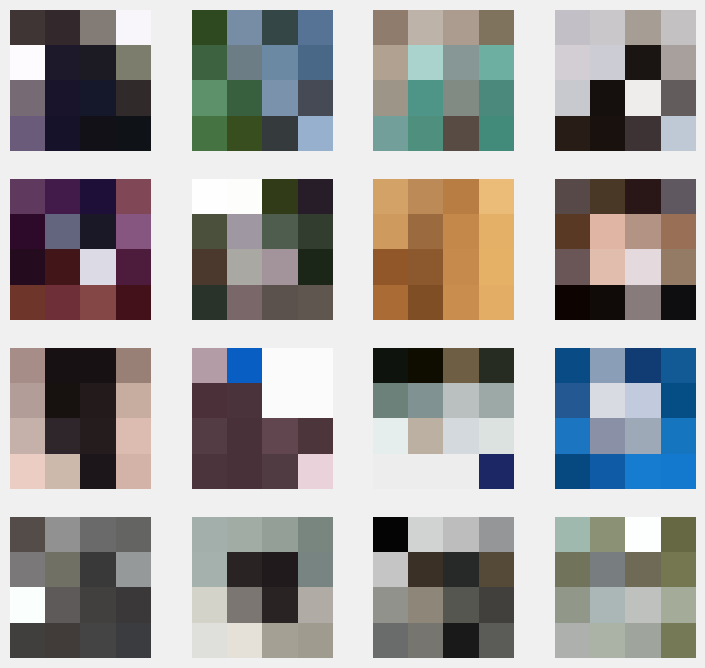

torch.Size([4, 4, 3])

In [62]:
# Test the image loader
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
training_data = ImageDataset(img_dir, 4)

figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [5]:
def generate_random_vector(shape: torch.Size):
    """
    Generate a random image with channels, width, and height defined by shape
    This is useful for testing that the discriminator can receive the correct inputs and outputs
    """
    channels = shape[0]
    width = shape[1]
    height = shape[2]
    return np.random.rand(channels, width, height)
# img = generate_random_vector(training_data[0].shape)
# plt.axis('off')
# plt.imshow(img)

In [6]:
class WeightedLayer(torch.nn.Module):
    """
    Used to linearly combine two layers
    The first layer is multiplied by alpha, while the second is multiplied by 1-alpha
    """
    def __init__(self, alpha, alpha_decay=0.0):
        super().__init__()
        self.alpha = alpha
        self.alpha_decay = alpha_decay
    def forward(self, x1, x2):
        self.alpha -= self.alpha_decay
        self.alpha = max(0, self.alpha)
        return self.alpha * x1 + (1- self.alpha) * x2


In [7]:
# Test that the weighted layer is working correctly

# Test using two numbers
layer = WeightedLayer(alpha=0.9) # Take 90% of x and 10% of x2
assert(layer(10, 1) == 9.1)

# Test using two arrays
a = np.ones(shape=(2, 2))
b = np.zeros(shape=(2, 2))
assert(np.all(layer(a,b) == 0.9))

In [114]:
# TODO, add weightedlayer
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # self.resolution = 3*4*4
        self.resolution = 4
        self.layers = []
        self.nn = torch.nn.Sequential()
        self.nnNew = torch.nn.Sequential()
        self.weighted = None
        

    def forward(self, x):
        # if (len(x.shape) > 1):
        #     x = x.view(-1)
        
        if self.weighted is not None:
            val = self.weighted(self.nn(x), self.nnNew(x))
            if (len(val.shape) > 1):
                print("ERROR on discriminator output size after weighted layer")
                print(f"Val is {val}")
            return val
        val = self.nn(x)
        if (len(val.shape) > 1):
            print("ERROR on discriminator output size")
            print(f"Val is {val}")
        return val
    
    def double_size(self):
        """
        !Must only be called after fully training the last layers!
        Adds an additional bundle layer to end of discriminator, doubling possible image size
        """
        if self.weighted is not None:
            self.nn = self.nnNew
        self.add_layer_bundle()
        self.resolution *= 2
        self.weighted = WeightedLayer(alpha=0.995, alpha_decay=0.001)
        
    def add_layer_bundle(self):
        """
        A layer bundle consists of a WeightedLayer, a Conv2D, a BatchNorm, and a ReLU
        each is added to the end of layers
        """ 
        in_channels = self.resolution
        out_channels = self.resolution * 2
        ConvLayer = torch.nn.Conv2d(in_channels, out_channels, kernel_size=2)
        BatchNormLayer = torch.nn.BatchNorm2d(out_channels)
        ReLULayer = torch.nn.ReLU()

        self.layers.append(ConvLayer)
        self.layers.append(BatchNormLayer)
        self.layers.append(ReLULayer)
        
    def finalize_model(self):
        if self.weighted is not None:
            self.nnNew = torch.nn.Sequential()
            for count, layer in enumerate(self.layers):
                self.nnNew.add_module(str(count), layer)
            
            self.nnNew.add_module("FinalConv", torch.nn.Conv2d(self.resolution, 1, 1, 4, 1, 0))
            self.nnNew.add_module("Sigmoid", torch.nn.Sigmoid())
            self.nnNew = self.nnNew.to(device)
        else:
            self.nn = torch.nn.Sequential()
            for count, layer in enumerate(self.layers):
                self.nn.add_module(str(count), layer)
            
            self.nn.add_module("FinalConv", torch.nn.Conv2d(self.resolution, 1, kernel_size=2))
            self.nn.add_module("Sigmoid", torch.nn.Sigmoid())
            self.nn = self.nn.to(device)
    def display_model(self):
        print(f"Resolution {self.resolution}")
        for layer in self.nn:
            print(layer)


In [99]:
discriminator = Discriminator().to(device)
discriminator.double_size()
discriminator.double_size()
discriminator.double_size()
discriminator.double_size()
discriminator.double_size()
discriminator.double_size()
discriminator.finalize_model()
discriminator.double_size()
discriminator.finalize_model()
discriminator.display_model()

Resolution 512
Conv2d(4, 8, kernel_size=(2, 2), stride=(1, 1))
BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU()
Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1))
BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU()
Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU()
Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU()
Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU()
Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU()
Conv2d(256, 1, kernel_size=(2, 2), stride=(1, 1))
Sigmoid()


In [100]:
# TODO: add weighted layer
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.resolution = 6
        self.layers = [
            torch.nn.ConvTranspose2d(6, 3, 4, 2, 1, bias=False),
            torch.nn.Tanh()
        ]
        self.weighted = None
        
    def forward(self, x):
        if self.weighted is not None:
            return self.weighted(self.nn(x), self.nnNew(x))
        return self.nn(x)
    
    def double_size(self):
        """
        !Must only be called after fully training the last layers!
        Adds an additional bundle layer to end of generator, doubling output size
        """
        if self.weighted is not None:
            self.nn = self.nnNew
        self.add_layer_bundle()
        self.resolution *= 2
        self.weighted = WeightedLayer(alpha = 0.995, alpha_decay = 0.001)

    def add_layer_bundle(self):
        """
        A layer bundle consists of a ConvTranspose2D, a BatchNorm, and a ReLU
        each is added to the beginning of layers
        """
        in_channels = self.resolution * 2
        out_channels = self.resolution
        ConvLayer = torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=1, padding=0, dilation=1, groups=1, bias=True)
        BatchNormLayer = torch.nn.BatchNorm2d(out_channels)
        ReLULayer = torch.nn.ReLU()
        
        self.layers = [ConvLayer, BatchNormLayer, ReLULayer] + self.layers
        
    def finalize_model(self):
        self.initialLayer = torch.nn.ConvTranspose2d(nz, self.resolution, kernel_size=2, stride=1, padding=0)
        if self.weighted is not None:
            self.nnNew = torch.nn.Sequential(self.initialLayer)
            for count, layer in enumerate(self.layers):
                self.nnNew.add_module(str(count+1), layer)
            self.nnNew = self.nnNew.to(device)
        else:
            self.nn = torch.nn.Sequential(self.initialLayer)
            for count, layer in enumerate(self.layers):
                self.nn.add_module(str(count+1), layer)
            self.nn = self.nn.to(device)
        
    def display_model(self):
        print(f"Resolution {self.resolution}")
        for layer in self.nn:
            print(layer)
        if self.nnNew is not None:
            print("\n\nNew Model:")
            for layer in self.nnNew:
                print(layer)


In [101]:
generator = Generator().to(device)
generator.double_size()
generator.finalize_model()
generator.double_size()
generator.finalize_model()
generator.double_size()
generator.finalize_model()
generator.double_size()
generator.finalize_model()
generator.double_size()
generator.finalize_model()
generator.double_size()
generator.finalize_model()
generator.double_size()
generator.finalize_model()
generator.display_model()

Resolution 768
ConvTranspose2d(100, 384, kernel_size=(2, 2), stride=(1, 1))
ConvTranspose2d(384, 192, kernel_size=(2, 2), stride=(1, 1))
BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU()
ConvTranspose2d(192, 96, kernel_size=(2, 2), stride=(1, 1))
BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU()
ConvTranspose2d(96, 48, kernel_size=(2, 2), stride=(1, 1))
BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU()
ConvTranspose2d(48, 24, kernel_size=(2, 2), stride=(1, 1))
BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU()
ConvTranspose2d(24, 12, kernel_size=(2, 2), stride=(1, 1))
BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU()
ConvTranspose2d(12, 6, kernel_size=(2, 2), stride=(1, 1))
BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU()
ConvTranspose2d(6, 3, kernel_size=(4, 4), stri

In [102]:
# Initialize weights for generator and discriminator
# From https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

In [115]:
def train(netG, netD, dataloader, num_epochs, device, criterion, optimizerD, optimizerG):   
    nz = 100
    real_label = 1.
    fake_label = 0
    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0
    
    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)

            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            print(output)
            
            
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()
    
            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()
    
            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()
    
            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    
            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())
    
            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
    
            iters += 1
    return (netG, netD, img_list)
def evaluate(generator):
    pass

In [116]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

discriminator.apply(weights_init)
generator.apply(weights_init)

discriminator.finalize_model()
generator.finalize_model()



loss = torch.nn.BCELoss()

discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)

resolution = 4
for resolution in [4, 8, 16, 32, 64, 128, 256]:
    # dataloader = ImageDataset(img_dir, resolution)
    training_data = ImageDataset(img_dir, resolution)
    # dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
    dataloader = torch.utils.data.DataLoader(training_data, batch_size=16)
    resolution *= 2
    print(discriminator)
    generator, discriminator, img_list = train(generator, discriminator, dataloader, num_epochs, device, loss, discriminator_optimizer, generator_optimizer)
    evaluate(generator)
    discriminator.double_size()
    discriminator.finalize_model()
    generator.double_size()
    generator.finalize_model()
print(discriminator)
print(generator)

Discriminator(
  (nn): Sequential(
    (FinalConv): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1))
    (Sigmoid): Sigmoid()
  )
  (nnNew): Sequential()
)
Starting Training Loop...
ERROR on discriminator output size
Val is tensor([[[0.5450, 0.5425],
         [0.5644, 0.5647],
         [0.4977, 0.5031]]], device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([0.5450, 0.5425, 0.5644, 0.5647, 0.4977, 0.5031], device='cuda:0',
       grad_fn=<ViewBackward0>)


ValueError: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([6])) is deprecated. Please ensure they have the same size.